## Imports and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from pathlib import Path
from collections import defaultdict
from genometechlab_plotting import setup_style, get_colors

setup_style("inline")
plot_colors = get_colors()

Loaded 7 Helvetica fonts


## Mod Codes

In [2]:
MOD_CODES = {
    'a': 'm6A',
    'm': 'm5C',
    '17802': 'Psi',
    '17596': 'Ino'
}


## Gene Identification Function

In [3]:
def get_all_genes(bed_path, gene_id_col=8, has_header=False, chunksize=100000):
    print(f"\nFirst pass: identifying all unique genes (using column {gene_id_col})...")
    all_genes = set()
    
    chunk_num = 0
    skiprows = 1 if has_header else 0
    
    for chunk in pd.read_csv(bed_path, sep='\t', header=None, 
                             chunksize=chunksize, 
                             usecols=[gene_id_col],
                             dtype={gene_id_col: str},
                             skiprows=skiprows):
        chunk_num += 1
        gene_values = chunk[gene_id_col].dropna().astype(str)
        unique_genes = gene_values.unique()
        all_genes.update(unique_genes)
        
        if chunk_num % 10 == 0:
            print(f"  Processed {chunk_num * chunksize:,} rows, found {len(all_genes):,} unique genes so far...")
            if chunk_num == 10:
                sample_genes = list(all_genes)[:5]
                print(f"    Sample genes: {sample_genes}")
    
    print(f"  Total unique genes found: {len(all_genes):,}")
    return all_genes

## CDS Modification Counting

In [4]:
def count_cds_modifications(bed_path, mod_code, gene_id_col=8, mod_col=3, 
                           score_col=6, feature_col=10, mod_percent_col=14,
                           has_header=False, min_score=20, min_mod_percent=20, 
                           chunksize=100000):
    print(f"  Counting CDS modifications for {MOD_CODES.get(mod_code, mod_code)}...")
    
    cds_counts = defaultdict(int)
    
    col_names = {
        mod_col: 'mod',
        score_col: 'score', 
        gene_id_col: 'gene_id',
        feature_col: 'feature_type',
        mod_percent_col: 'fp_adjusted_mod_percent'
    }
    
    chunk_num = 0
    total_cds = 0
    skiprows = 1 if has_header else 0
    
    for chunk in pd.read_csv(bed_path, sep='\t', header=None,
                             chunksize=chunksize,
                             usecols=list(col_names.keys()),
                             skiprows=skiprows):
        chunk_num += 1
        
        chunk.rename(columns=col_names, inplace=True)
        
        chunk['mod'] = chunk['mod'].astype(str)
        chunk['score'] = pd.to_numeric(chunk['score'], errors='coerce')
        chunk['fp_adjusted_mod_percent'] = pd.to_numeric(chunk['fp_adjusted_mod_percent'], errors='coerce')
        chunk['fp_adjusted_mod_percent'] = chunk['fp_adjusted_mod_percent'].clip(lower=0)
        chunk['gene_id'] = chunk['gene_id'].astype(str)
        
        filtered = chunk[
            (chunk['mod'] == mod_code) &
            (chunk['score'] >= min_score) &
            (chunk['fp_adjusted_mod_percent'] >= min_mod_percent) &
            (chunk['feature_type'] == 'CDS')
        ]
        
        gene_counts = filtered.groupby('gene_id').size()
        for gene, count in gene_counts.items():
            cds_counts[gene] += count
            total_cds += count
        
        if chunk_num % 10 == 0:
            print(f"    Processed {chunk_num * chunksize:,} rows, found {total_cds:,} CDS sites so far...")
    
    print(f"    Total CDS sites found: {total_cds:,}")
    return dict(cds_counts)

## Summary Table

In [5]:
def create_summary_table(all_counts_data, all_genes_list, output_path=None):
    print("\nCreating summary table...")
    
    summary_data = []
    
    for mod_code, mod_name in MOD_CODES.items():
        cds_counts = all_counts_data[mod_code]
        
        total_genes = len(all_genes_list)
        genes_with_mods = np.sum(cds_counts > 0)
        genes_without_mods = np.sum(cds_counts == 0)
        total_cds_sites = np.sum(cds_counts)
        
        mean_all = cds_counts.mean()
        median_all = np.median(cds_counts)
        
        non_zero_data = cds_counts[cds_counts > 0]
        mean_non_zero = non_zero_data.mean() if len(non_zero_data) > 0 else 0
        median_non_zero = np.median(non_zero_data) if len(non_zero_data) > 0 else 0
        
        summary_data.append({
            'Modification': mod_name,
            'Code': mod_code,
            'Total_Genes': total_genes,
            'Genes_With_Mods': genes_with_mods,
            'Genes_Without_Mods': genes_without_mods,
            'Percent_With_Mods': (genes_with_mods / total_genes * 100) if total_genes > 0 else 0,
            'Total_CDS_Sites': int(total_cds_sites),
            'Mean_Sites_All_Genes': mean_all,
            'Mean_Sites_Modified_Genes': mean_non_zero,
            'Median_Sites_All_Genes': median_all,
            'Median_Sites_Modified_Genes': median_non_zero
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    print("\n" + "="*80)
    print("SUMMARY TABLE - CDS Modifications Meeting 20/20 Criteria")
    print("="*80)
    print(summary_df.to_string(index=False))
    print("="*80)
    
    if output_path:
        summary_df.to_csv(output_path, index=False)
        print(f"\nSummary table saved to: {output_path}")
    
    return summary_df

## Plotting

In [6]:
def plot_cds_distributions_efficient(bed_path, sample_name, output_path, 
                                    gene_id_col=8, mod_col=3, score_col=6, 
                                    feature_col=10, mod_percent_col=14,
                                    has_header=False, min_score=20, min_mod_percent=20,
                                    summary_table_path=None):
    
    all_genes = get_all_genes(bed_path, gene_id_col, has_header)
    all_genes_list = list(all_genes)
    print(f"\nTotal unique genes in dataset: {len(all_genes_list):,}")
    
    if len(all_genes_list) <= 1:
        print("\nWARNING: Only found 1 or fewer unique genes!")
        print("This likely means the wrong column is being used for gene IDs.")
        print("Please check the file structure and specify the correct column.")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    mod_colors = {
        'a': plot_colors[0],
        'm': plot_colors[3],
        '17802': plot_colors[1],
        '17596': plot_colors[2]
    }
    
    standardized_bins = np.arange(0, 52, 1)
    
    print("\nSecond pass: counting CDS modifications by type...")
    
    all_counts_data = {}
    max_count_overall = 0
    
    for mod_code, mod_name in MOD_CODES.items():
        cds_counts_dict = count_cds_modifications(
            bed_path, mod_code, gene_id_col, mod_col, score_col, 
            feature_col, mod_percent_col, has_header, min_score, min_mod_percent
        )
        
        cds_counts = []
        for gene in all_genes_list:
            count = cds_counts_dict.get(gene, 0)
            cds_counts.append(min(count, 51))
        
        cds_counts = np.array(cds_counts)
        all_counts_data[mod_code] = cds_counts
        
        counts, _ = np.histogram(cds_counts, bins=standardized_bins)
        max_count_overall = max(max_count_overall, counts.max())
    
    summary_df = create_summary_table(all_counts_data, all_genes_list, summary_table_path)
    
    y_min = 0.5
    y_max = max_count_overall * 2
    
    print("\nPlotting with standardized axes...")
    
    for idx, (mod_code, mod_name) in enumerate(MOD_CODES.items()):
        ax = axes[idx]
        cds_counts = all_counts_data[mod_code]
        
        if len(cds_counts) > 0:
            counts, bin_edges = np.histogram(cds_counts, bins=standardized_bins)
            
            bin_labels = []
            for i in range(len(counts)):
                left = int(bin_edges[i])
                if left == 50:
                    bin_labels.append('>50')
                else:
                    bin_labels.append(str(left))
            
            bars = ax.bar(range(len(counts)), counts, 
                         color=mod_colors.get(mod_code, 'gray'),
                         alpha=0.8,
                         edgecolor='black',
                         linewidth=0.2,
                         width=1.0)
            
            ax.set_xticks(range(len(counts)))
            tick_labels = []
            for i in range(len(bin_labels)):
                if i == 0 or i == 25 or i == 50 or i == len(bin_labels) - 1:
                    tick_labels.append(bin_labels[i])
                elif i % 10 == 0:
                    tick_labels.append(bin_labels[i])
                else:
                    tick_labels.append('')
            
            ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=8)
            
            ax.set_yscale('log')
            ax.set_ylim(y_min, y_max)
            
            ax.set_xlabel('CDS Sites per Gene')
            ax.set_ylabel('Gene Count (log scale)')
            
            genes_with_zero = np.sum(cds_counts == 0)
            genes_with_mods = np.sum(cds_counts > 0)
            genes_over_50 = np.sum(cds_counts > 50)
            
            ax.set_title(f'{mod_name} ({mod_code})\n'
                        f'{genes_with_zero:,} genes with 0 mods, '
                        f'{genes_with_mods:,} with ≥1 mod')
            
            mean_val = cds_counts.mean()
            median_val = np.median(cds_counts)
            
            non_zero_data = cds_counts[cds_counts > 0]
            mean_non_zero = non_zero_data.mean() if len(non_zero_data) > 0 else 0
            
            stats_text = (f'Mean (all): {mean_val:.2f}\n'
                         f'Mean (>0): {mean_non_zero:.2f}\n'
                         f'Median: {median_val:.0f}')
            if genes_over_50 > 0:
                stats_text += f'\n>50 sites: {genes_over_50}'
            
            ax.text(0.98, 0.98, stats_text,
                   transform=ax.transAxes,
                   verticalalignment='top',
                   horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
                   fontsize=9)
            
            ax.grid(True, alpha=0.3, axis='y')
            
        else:
            ax.text(0.5, 0.5, f'No {mod_name} data',
                   transform=ax.transAxes,
                   ha='center', va='center')
            ax.set_title(f'{mod_name} ({mod_code})')
            ax.set_ylim(y_min, y_max)
    
    for idx, ax in enumerate(axes):
        letter = chr(65 + idx)
        ax.text(-0.15, 1.1, letter, transform=ax.transAxes,
               fontsize=16, fontweight='bold', va='top', ha='left')
    
    plt.suptitle(f'{sample_name}\nCDS Modification Distribution (0-50+ sites per gene, bin width = 1)\n'
                f'Filters: score ≥ {min_score}, modification ≥ {min_mod_percent}%',
                fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    
    if output_path:
        with PdfPages(output_path) as pdf:
            pdf.savefig(fig, bbox_inches='tight')
        print(f"\nPlot saved to: {output_path}")
    else:
        plt.show()

## Paths

In [7]:
# Input file and parameters
INPUT_BED = '../Exemplar_Data/annotated_output/08_07_24_GM12878_chr12-112000000-114000000_annotated.bed'
SAMPLE_NAME = "08_07_24_GM12878_chr12-112000000-114000000"  # Set to None to auto-generate from filename
OUTPUT_PDF = None   # Set to file path to save PDF, or None to display inline
SUMMARY_TABLE_PATH = None  # Set to file path to save summary CSV

# Filtering parameters
MIN_SCORE = 20
MIN_MOD_PERCENT = 20

# Column indices (0-based)
GENE_ID_COL = 8
MOD_COL = 3
SCORE_COL = 6
FEATURE_COL = 10
MOD_PERCENT_COL = 14

# File settings
HAS_HEADER = False  # Set to True if file has header row
CHUNKSIZE = 100000  # Rows to process at once

## Run Analysis

Processing: ../Exemplar_Data/annotated_output/08_07_24_GM12878_chr12-112000000-114000000_annotated.bed
Using chunk size: 100,000 rows

First pass: identifying all unique genes (using column 8)...
  Processed 1,000,000 rows, found 29 unique genes so far...
    Sample genes: ['ENSG00000186710.12', 'ENSG00000179295.19', 'ENSG00000151176.8', 'ENSG00000123064.13', 'ENSG00000198270.14']
  Total unique genes found: 34

Total unique genes in dataset: 34

Second pass: counting CDS modifications by type...
  Counting CDS modifications for m6A...
    Processed 1,000,000 rows, found 45 CDS sites so far...
    Total CDS sites found: 46
  Counting CDS modifications for m5C...
    Processed 1,000,000 rows, found 30 CDS sites so far...
    Total CDS sites found: 32
  Counting CDS modifications for Psi...
    Processed 1,000,000 rows, found 2 CDS sites so far...
    Total CDS sites found: 2
  Counting CDS modifications for Ino...
    Processed 1,000,000 rows, found 5 CDS sites so far...
    Total CDS s

/tmp/ipykernel_1086969/3715964104.py:143: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


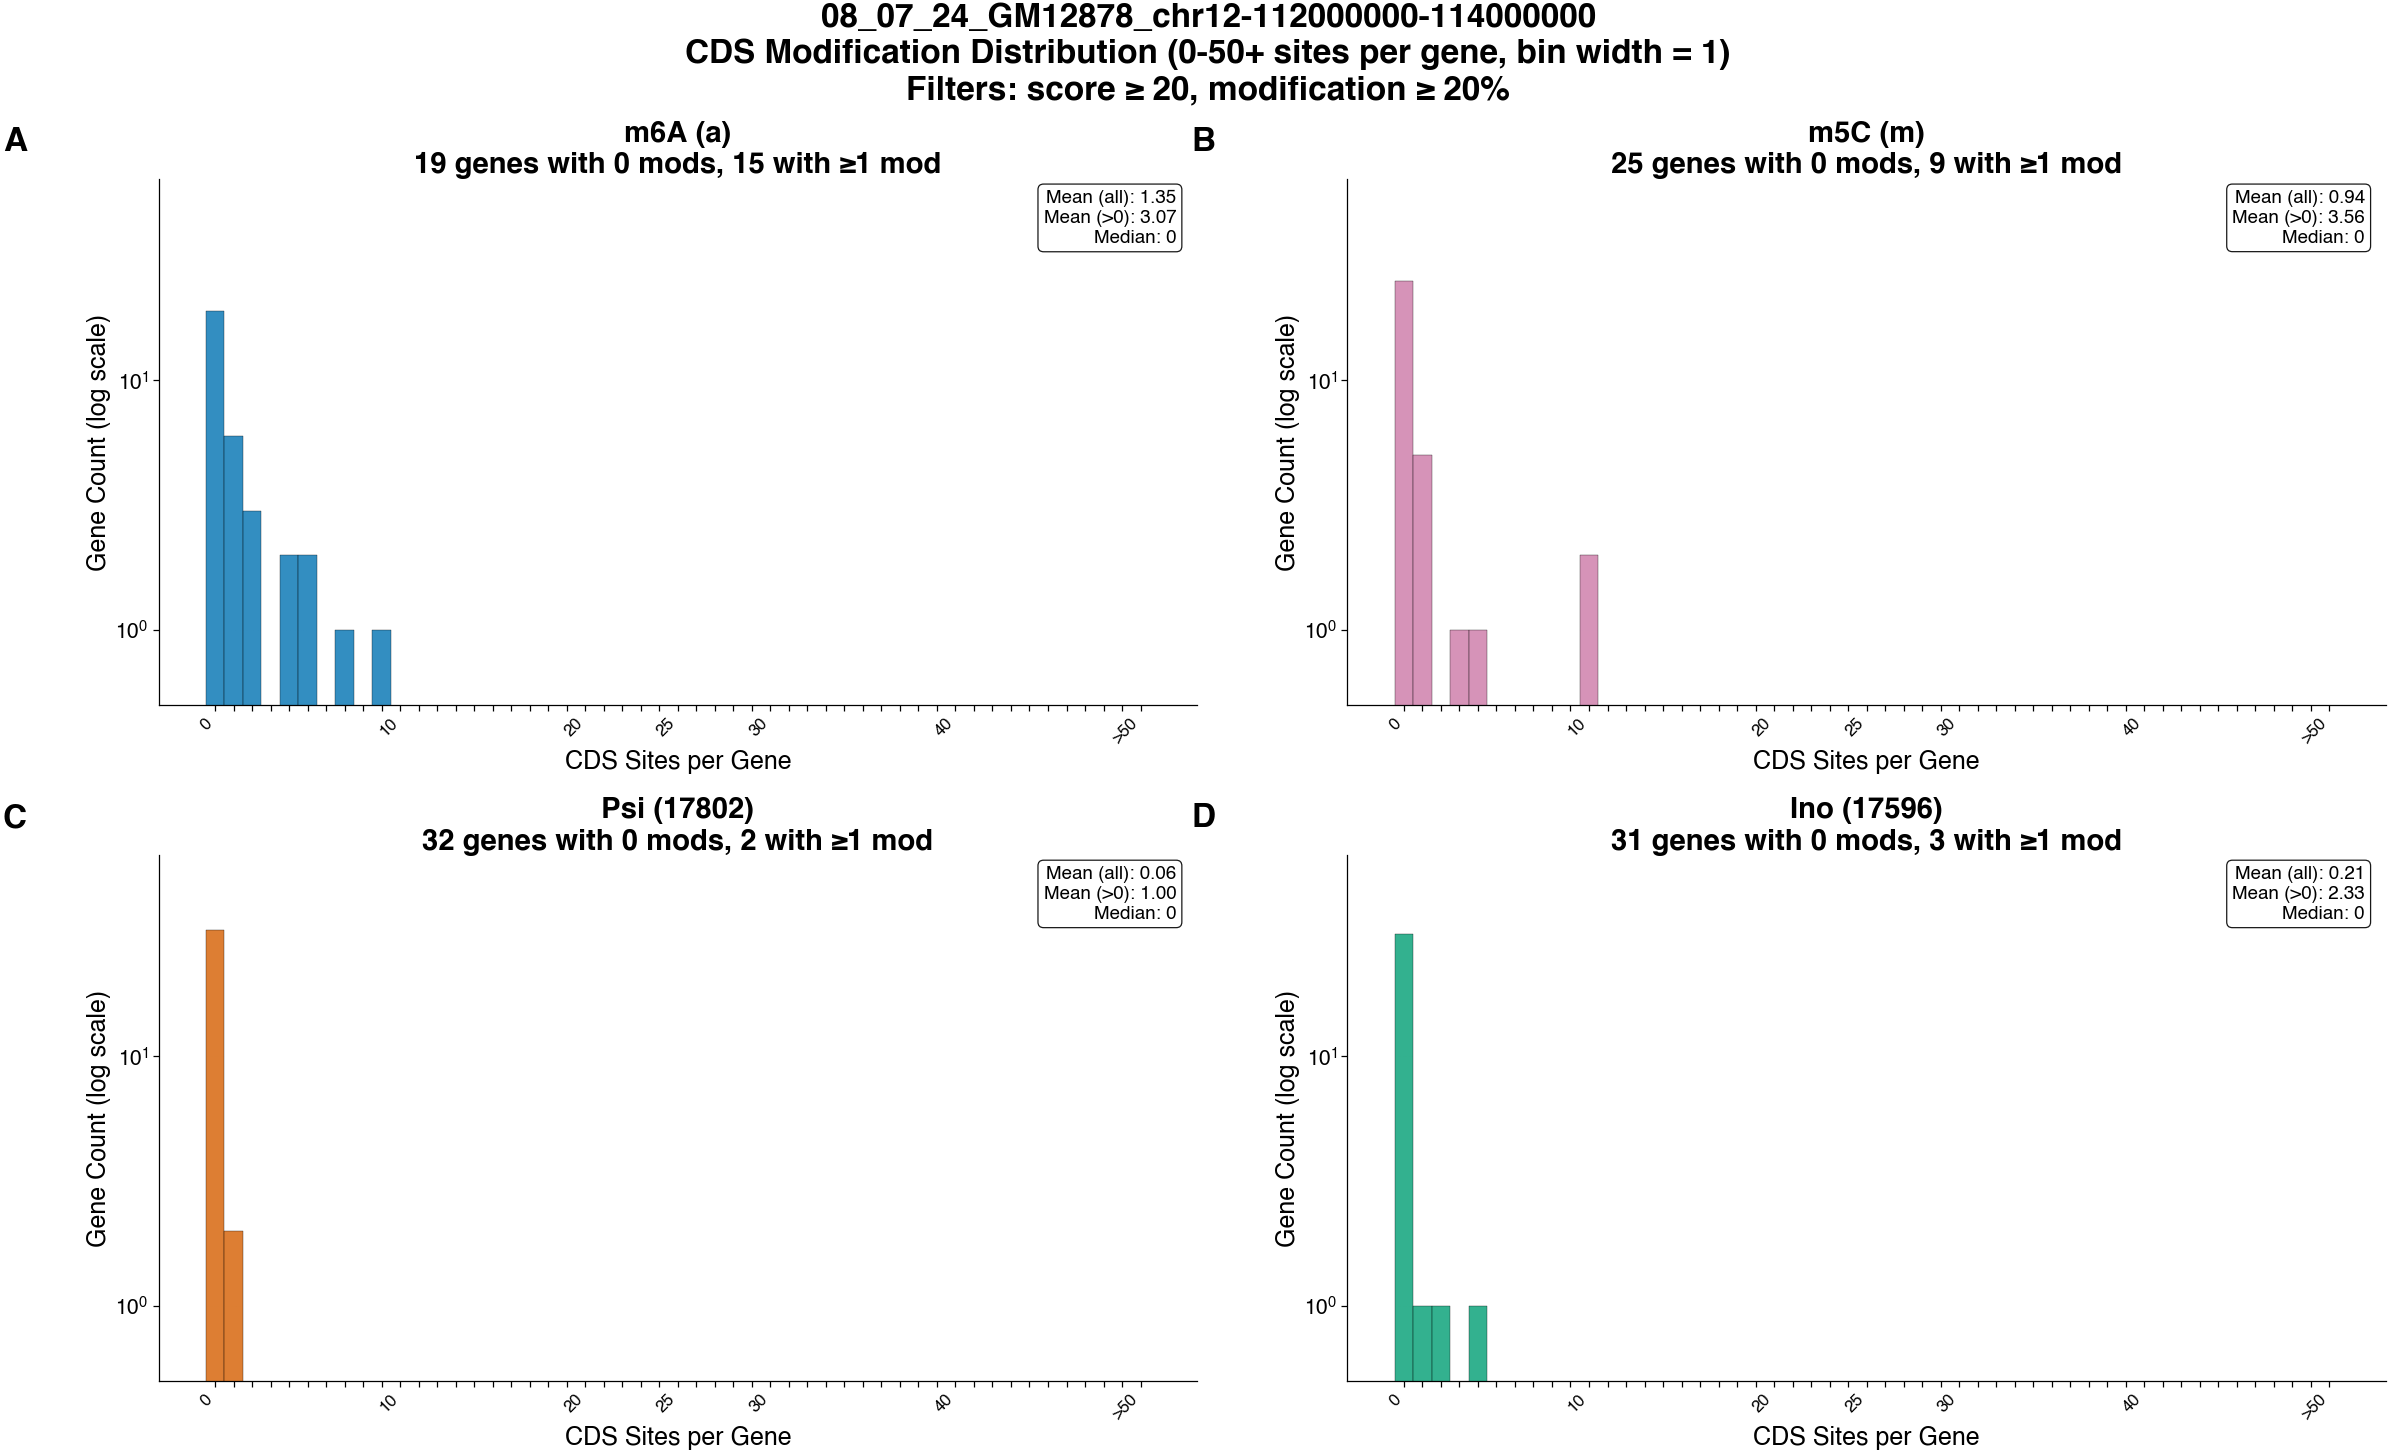

In [8]:
%matplotlib inline
# Generate sample name if not provided
if SAMPLE_NAME is None:
    SAMPLE_NAME = Path(INPUT_BED).stem.replace('_annotated', '')

# Generate summary table path if not provided
if SUMMARY_TABLE_PATH is None and OUTPUT_PDF:
    SUMMARY_TABLE_PATH = str(Path(OUTPUT_PDF).with_suffix('.summary.csv'))

print(f"Processing: {INPUT_BED}")
print(f"Using chunk size: {CHUNKSIZE:,} rows")

# Run the analysis
plot_cds_distributions_efficient(
    INPUT_BED, SAMPLE_NAME, OUTPUT_PDF, 
    GENE_ID_COL, MOD_COL, SCORE_COL,
    FEATURE_COL, MOD_PERCENT_COL,
    HAS_HEADER, MIN_SCORE, MIN_MOD_PERCENT,
    SUMMARY_TABLE_PATH
)